# ML task to combine GR and nuclear physics with deep learning techniques to model and predict the mass-radius relationship of neutron stars 

### <div style= 'color: yellow'> Define the TOV equations and polytropic EOS

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as pi
from scipy.integrate import odeint

# conversion constants to work in geometrized units where G = c = 1
msun = 1.476600 # solar mass in km aka solar gravitational radius
dkm = 1.3234e-6 # conversion from Mev/fm^3 to km^-2
cgs1 = 1.7827e+12 # MeV/fm^3 to g/cm^3


def f(ρ, κ, γ): # ploytropic EOS
    """
    Solves the general polytrope: p = κ * ε^γ 
    but ε^γ = ρ^γ * c^2γ and c = 1 in our case
    So the polytrope becomes:  p = κ * ρ^γ
    So the polytrope becomes:  p = κ * ρ^γ

    Returns:
    -------
    p = κ * ρ^γ
    
    """  
    return κ*(ρ**γ)

def TOV(logρ_c, κ, γ): # TOV Structure equations
    """
    Solves the TOV equations numerically using Euler integration with small step 
    size dr=0.001. It starts from a central density ρ_c
    and integrates outward until the pressure drops to zero.

    Returns:
    -------
    m/msum: Mass of the Neutron Star in solar masses
    r: Radius of the Neutron Star
    p: Pressure in km^-2 (geometrized units)

    """
    dr = 0.001 # increment in r
    ρ_c = pow(10,logρ_c)*dkm/cgs1 # undoing the log and convertinG to the right units to get central mass density
    m = 0.0 # starting mass
    r = 0.000001 # starting radius
    p = f(ρ_c, κ, γ) # Calculate the polytropic EOS
    ε = ρ_c+p/(γ-1.) # Energy density (ε)
    while p >= 0:
        p += -(ε+p)*(m+4.0*pi*(r**3.0)*p)*dr/(r*(r-2.0*m)) # TOV equation 1 in geometrized units
        if p <= 0:
            break
        m += 4.0*pi*(r**2.0)*ε*dr # TOV equation 2 in geometrized units
        r += dr
        ε = (p/κ)**(1.0/γ)+p/(γ-1.) # Update energy density
    return m/msun, r, p/dkm * 1.602176634e33 # m/msun is the dimensionless mass of the star

### <div style= 'color: yellow'> Mass-Radius relation for a single EOS of a Neutron Star

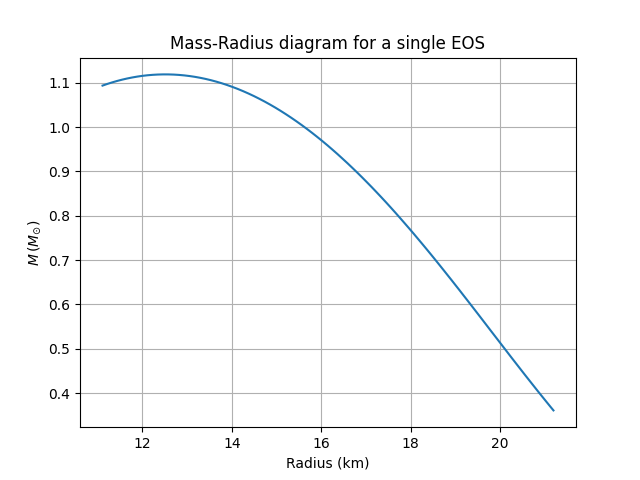

In [3]:
logρ_c_array = np.linspace(14.,15.4,100) # 100 evenly spaced nos. from 14.0 to 15.4
κ = 110
γ = 1.9
seq=[]
for logρ_c in logρ_c_array:
    m, r, p = TOV(logρ_c,κ,γ)
    seq.append((m/msun,r, p))
    
seq=np.vstack(seq)

plt.figure()
plt.plot(seq[:,1], seq[:,0])
plt.xlabel('Radius (km)')
plt.ylabel(r'$M \, (M_{\odot})$')
plt.title("Mass-Radius diagram for a single EOS")
plt.grid()

### <div style= 'color: yellow'> Mass-Radius and Pressure-Radius relation for a single EOS of a Neutron Star

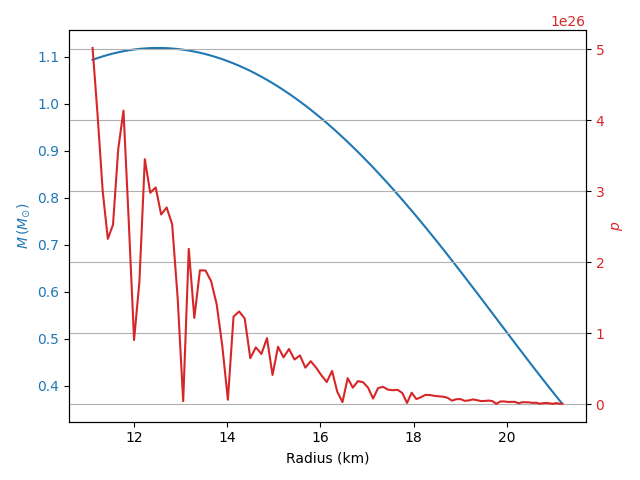

In [4]:
fig, ax1 = plt. subplots()

color = 'tab:blue'
ax1.set_xlabel('Radius (km)')
ax1.set_ylabel(r'$M \, (M_{\odot})$', color = color)
ax1.plot(seq[:,1], seq[:,0], label = "mass", color= color)
ax1.tick_params(axis = 'y', labelcolor= color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$p$', color = color)
ax2.plot(seq[:,1], -seq[:,2], label = "mass", color= color)
ax2.tick_params(axis = 'y', labelcolor= color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid()


### <div style= 'color: yellow'> Generating a dataset of 10,000 different EOS

In [ ]:
# Number of EOS samples
num_samples = 10000  

# Sample central mass density values (in dyn/cm²)
logρ_c_samples = np.random.uniform(low=14,
                                   high=15.5,
                                   size=(num_samples, 1))

# Sample 10,000 EOS configurations with random κ and γ
EOS_params = np.random.uniform(low = [100.0, 1.85], 
                               high = [120.0, 1.95], 
                               size = (num_samples, 2)) # rows x columns

# Placeholder for Mass, Radius, Tidal Deformability
MR_data = []

# Generate dataset by running the TOV solver for each of the 10,000 configurations
for i in range(num_samples):
    logρ_c = logρ_c_samples[i, 0] # get logρ_c value 
    params = EOS_params[i] # get values for κ and γ
    M, R, P = TOV(logρ_c, params[0], params[1]) # calculate M and R
    MR_data.append([M,R])

# Convert to NumPy array
EOS_data = np.hstack([logρ_c_samples, EOS_params, np.array(MR_data)])

# Save dataset
np.save("EOS_dataset.npy", EOS_data)

In [ ]:
EOS_data # logρ_c, κ, γ, M, R

### <div style= 'color: yellow'> Loading the generated dataset, normalizing it and splitting it into training and validation datasets

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = np.load("EOS_dataset.npy")
X = torch.tensor(data[:, :3], dtype=torch.float32)
# Nx3 matrix input containing log_rho_c, κ, γ (the input features)
y = torch.tensor(data[:, 3:5], dtype=torch.float32)
# Nx2 matrix input containing Mass, Radius (the targets)

# Normalize the dataset for better training convergence
X_mean, X_std = X.mean(dim=0), X.std(dim=0)
y_mean, y_std = y.mean(dim=0), y.std(dim=0)
X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std

# Split into training(80%) and validation(20%) sets
train_size = int(0.8 * len(X_norm))
X_train, X_val = X_norm[:train_size], X_norm[train_size:]
y_train, y_val = y_norm[:train_size], y_norm[train_size:]

# Convert data to PyTorch tensors
X_train, y_train = X_train.view(-1, 3), y_train.view(-1, 2)
X_val, y_val = X_val.view(-1, 3), y_val.view(-1, 2)
# -1 tells PyTorch, “figure out this dimension automatically.”
# Example: If the tensor has 300 elements and you say .view(-1, 3), 
# PyTorch figures out the first dimension should be 100 because 100×3=300.

$$Splitting\ datasets$$
* X is a tensor containing all the <b>input values</b>: logρ_c, κ, γ 
* y is a tensor containing all the <b>target values</b>:  M and R

$$Training$$
* X_train is a tensor containing 80% of the <b>input</b> dataset
* y_train is a tensor containing 80% of the <b>target</b> dataset

$$Validation$$
* X_val is a tensor containing 20% of the <b>input</b> dataset
* y_val is a tensor containing 20% of the <b>target</b> dataset

### <div style= 'color: yellow'> Defining and training the Neural Netwok

Epoch [100/1000], Loss: 0.0012
Epoch [200/1000], Loss: 0.0005
Epoch [300/1000], Loss: 0.0003
Epoch [400/1000], Loss: 0.0002
Epoch [500/1000], Loss: 0.0001
Epoch [600/1000], Loss: 0.0001
Epoch [700/1000], Loss: 0.0002
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0001
Epoch [1000/1000], Loss: 0.0001


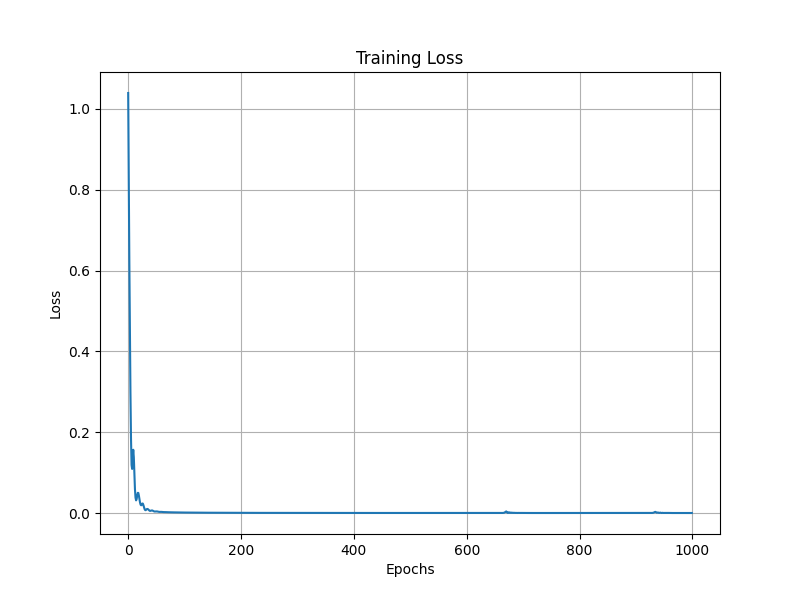

In [7]:
# Define Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=50, output_dim=2):
        # input_dim = 3, input features logρ_c, κ, and γ
        # hidden_dim = 50, each hidden layer has 50 neurons
        # output_dim = 2D vector predicting mass and radius
        super(SimpleNN, self).__init__()
        # fully connected dense layers
        self.fc1 = nn.Linear(input_dim, hidden_dim) # first layer maps 3 inputs to 50 neurons
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # second layer maps 50 neurons to 50 neurons
        self.fc3 = nn.Linear(hidden_dim, output_dim) # Output layer maps 50 neurons to 2 outputs
        self.relu = nn.ReLU() # ReLU Rectified Linear Unit is a non linear activation function. 
        # It is applied after each hidden layer to introduce non-linearity
    
    def forward(self, x): # Forward pass (Data Flow)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the model, making it ready to be trained
model = SimpleNN() # Creates a network object with randomly initialized weights and biases.

# Loss function and Optimizer
criterion = nn.MSELoss() # Mean Squared Error is used for regression.
# It computes the average squared difference between predicted and actual values.

optimizer = optim.Adam(model.parameters(), lr=0.01) # Adam Optimizer: efficient gradient descent method
# Adjusts model weights to minimize the loss. lr (learning rate): how much weights change per step

# Training the model
epochs = 1000
losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad() # Clears previous gradients
    outputs = model(X_train) # Predicts outputs (mass, radius) from input features
    loss = criterion(outputs, y_train) # Compute loss between predicted and actual values using MSE.
    loss.backward() # Backpropagation: Computes gradients of the loss with respect to model weights.
    optimizer.step() # Updates the model’s weights using the computed gradients and the Adam optimizer.
    losses.append(loss.item()) # Stores the scalar loss value of the current epoch to plot later.
    
    if (epoch + 1) % 100 == 0: # Print progress every 100 epochs
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()

# Save trained model
torch.save(model.state_dict(), "simple_nn_model.pth")

### <div style= 'color: yellow'> Model Evaluation and Comparison

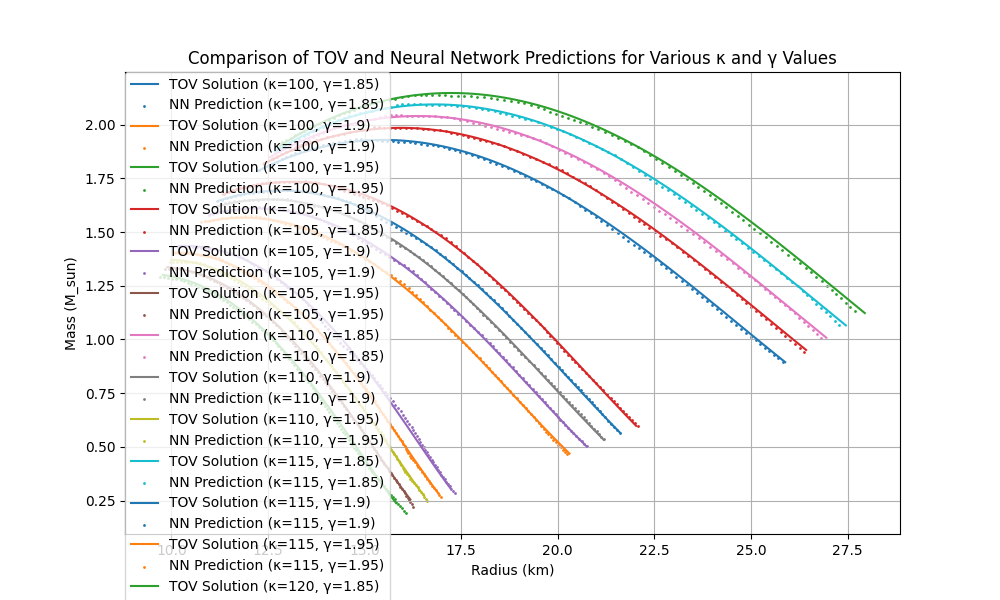

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Prepare ranges for κ and γ to test the model
kappa_values = [100, 105, 110, 115, 120]  # Example values for κ
gamma_values = [1.85, 1.9, 1.95]  # Example values for γ
logρ_c_array = np.linspace(14., 15.4, 100) # Array for 100 logρ_c values

# Initialize lists to store results
predicted_mass = [] # From the neural network
predicted_radius = []
# Each will end up as a list of length 15 (one per (κ,γ) pair).
# Each element is itself a list of length 100 (one per logρ_c).

original_mass = [] # From the TOV solver
original_radius = []

# Iterate over all the κ and γ values = 15 combinations of EOS parameters
for κ in kappa_values:
    for γ in gamma_values:
        # Store 100 results for this κ and γ combination
        predicted_mass_single = []
        predicted_radius_single = []

        original_mass_single = []
        original_radius_single = []

        # Iterate over all the 100 central density values
        for logρ_c in logρ_c_array:
            # Prepare input tensor for prediction in a 1 x 3 format
            input_tensor = torch.tensor([[logρ_c, κ, γ]], dtype=torch.float32)
            
            # Normalize the input data using the training mean and std. Same as training
            input_norm = (input_tensor - X_mean) / X_std
            
            # Make predictions with the trained model
            with torch.no_grad(): # Disables gradient computation (saves memory and compute since we're only doing inference).
                prediction = model(input_norm)
            
            # Convert the prediction tensor to NumPy and denormalize the predicted mass and radius
            prediction_np = prediction.detach().numpy()[0]  # Convert to NumPy and get the first element
            # Denormalize the predicted mass and radius. Convert prediction from PyTorch tensor → NumPy array.
            mass_pred, radius_pred = prediction_np * y_std.numpy() + y_mean.numpy()
            # mass_pred in M⊙ (dimensionless).
            # radius_pred in km.
            
            # Calculate original mass and radius using TOV solver
            M_orig, R_orig, P_orig = TOV(logρ_c, κ, γ)
            
            # Store the results
            predicted_mass_single.append(mass_pred)
            predicted_radius_single.append(radius_pred)
            original_mass_single.append(M_orig)
            original_radius_single.append(R_orig)

        # After iterating over logρ_c, store the results for each κ, γ pair
        predicted_mass.append(predicted_mass_single)
        predicted_radius.append(predicted_radius_single)
        original_mass.append(original_mass_single)
        original_radius.append(original_radius_single)

# Plotting Mass vs Radius for each κ, γ combination
plt.figure(figsize=(10, 6))

# Iterate over the stored results and plot each κ-γ combination
for i, (κ, γ) in enumerate([(k, g) for k in kappa_values for g in gamma_values]):
    plt.plot(original_radius[i], original_mass[i], label=f"TOV Solution (κ={κ}, γ={γ})", linestyle='-')
    plt.scatter(predicted_radius[i], predicted_mass[i], label=f"NN Prediction (κ={κ}, γ={γ})", marker='o', s=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M_sun)")
plt.legend(loc='upper left', borderaxespad=0.)
plt.title("Comparison of TOV and Neural Network Predictions for Various κ and γ Values")
plt.grid()
plt.savefig("mass_radius_comparison.png", dpi=300)
plt.show()


The 15 curves in the plot correspond to 15 different combinations of $\kappa$ and $\gamma$. 

Each of these combinations have 100 different $logρ_c$ values for which 100 different $mass$ and $radius$ values are predicted. (i.e. $predicted\_mass\_single$ and $predicted\_radius\_single$)\
Similary for each of these 100 different $logρ_c$ values, 100 different $mass$ and $radius$ values are caculated using the TOV Solver. (i.e. $original\_mass\_single$ and $original\_radius\_single$)

The 100 different predicted $M$ and $R$ values, from the 100 different $logρ_c$ values, for one single combination of $\kappa$ and $\gamma$, are append to $predicted\_mass$ and $predicted\_radius$ as a single list entry.\
Same with $original\_mass$ and $original\_radius$ as well

In total $predicted\_mass$ and $predicted\_radius$ will comprise of 15 sunch entries.\
Same with $original\_mass$ and $original\_radius$ as well.

In [ ]:
len(predicted_mass[0]) # this is predicted_mass_single

In [ ]:
len(original_mass[0]) # this is original_mass_single